# Data mining Final Project - Movie Recommendation System

## Table of Content:

* Objective

* Explorative Data Analysis
    -  Data loading
    -  Data viewing
    -  Data cleaning
    -  Data slicing
    -  Data mapping
    
* Recommendation models
    -  Recommend with Collaborative Filtering
    -  Recommend with Pearsons' R correlation

# Objective
<br>
Learn from data and recommend best TV shows to users, based on self & others behaviour
<br>

# Explorative Data Analysis

## Data Format & Data Importing

Data Format: 
### rating.csv

* Movie ID (as first line of each new movie record / file)
* UserID
* Rating (1 to 5)
* Date they gave the ratings

### Movies.csv
- Movie ID
- title
- genres



Let's import the library we needed before we get started:

In [2]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

Next let's load first data file and get a feeling of how huge the dataset is:

In [24]:

column_names = ['user_id', 'movie_id', 'rating', 'timestamp']
df = pd.read_csv('small/ratings.csv', header=0,  names=column_names)
df['rating'] = df['rating'].astype(float)

print('Dataset 1 shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::50000, :])
df.head()

Dataset 1 shape: (100836, 4)
-Dataset examples-
        user_id  movie_id  rating   timestamp
0             1         1     4.0   964982703
50000       322      1032     3.0  1217674947
100000      610      6978     4.0  1479542837


,user_id,movie_id,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [26]:
column_names = ['movie_id', 'title', 'genres']
movie_titles = pd.read_csv("small/movies.csv", header=0, names=column_names)
movie_titles.head()

,movie_id,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [27]:
df = pd.merge(df,movie_titles,on='movie_id')
df.head()

,user_id,movie_id,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


## Visualization Imports

Let's create a ratings dataframe with average rating and number of ratings:

In [29]:
# Mean of Rating by title
df.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Gena the Crocodile (1969)              5.0
True Stories (1986)                    5.0
Cosmic Scrat-tastrophe (2015)          5.0
Love and Pigeons (1985)                5.0
Red Sorghum (Hong gao liang) (1987)    5.0
Name: rating, dtype: float64

In [30]:
# Count of Rating by title
df.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Forrest Gump (1994)                 329
Shawshank Redemption, The (1994)    317
Pulp Fiction (1994)                 307
Silence of the Lambs, The (1991)    279
Matrix, The (1999)                  278
Name: rating, dtype: int64

In [32]:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings.head()

,rating
title,
'71 (2014),4.0
'Hellboy': The Seeds of Creation (2004),4.0
'Round Midnight (1986),3.5
'Salem's Lot (2004),5.0
'Til There Was You (1997),4.0


In [34]:
ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
ratings.head()

,rating,num of ratings
title,,
'71 (2014),4.0,1
'Hellboy': The Seeds of Creation (2004),4.0,1
'Round Midnight (1986),3.5,2
'Salem's Lot (2004),5.0,1
'Til There Was You (1997),4.0,2


In [48]:
ratings.sort_values('num of ratings',ascending=False).head(10)

,rating,num of ratings
title,,
Forrest Gump (1994),4.164134,329
"Shawshank Redemption, The (1994)",4.429022,317
Pulp Fiction (1994),4.197068,307
"Silence of the Lambs, The (1991)",4.161290,279
"Matrix, The (1999)",4.192446,278
Star Wars: Episode IV - A New Hope (1977),4.231076,251
Jurassic Park (1993),3.750000,238
Braveheart (1995),4.031646,237
Terminator 2: Judgment Day (1991),3.970982,224


Total Movie Count  and Rating count

In [56]:
p = df.groupby('rating')['rating'].agg(['count'])

# get movie counta
movie_count = df.isnull().sum()[1]

# get customer count
cust_count = df['user_id'].nunique() - movie_count

# get rating count
rating_count = df['user_id'].count() - movie_count

print('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count))

Total pool: 0 Movies, 610 customers, 100,836 ratings given


<AxesSubplot:title={'center':'Num of rating distribution'}>

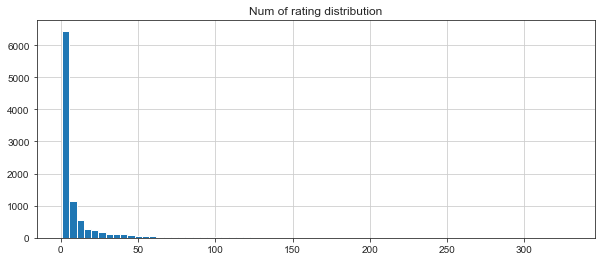

In [36]:
plt.figure(figsize=(10,4))
plt.title("Num of rating distribution")
ratings['num of ratings'].hist(bins=70)

We can see only few movies are popular amoung viewer

<AxesSubplot:title={'center':'rating distribution'}>

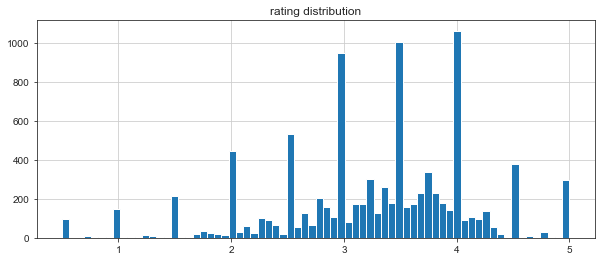

In [39]:
plt.figure(figsize=(10,4))
plt.title("rating distribution")
ratings['rating'].hist(bins=70)

Text(1, 1, 'It shows more ratings it has, the better rating it is')

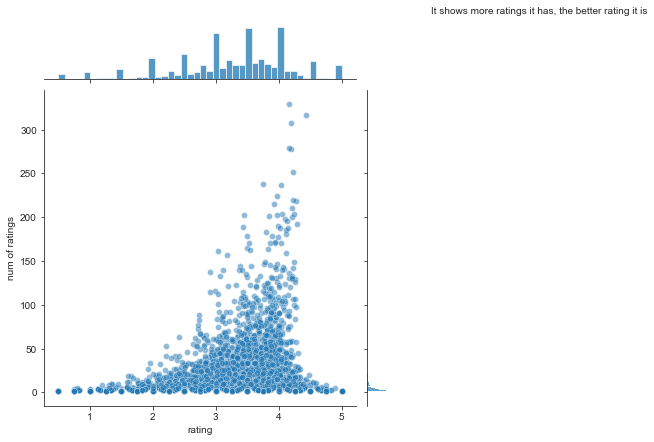

In [47]:
sns.jointplot(x='rating',y='num of ratings',data=ratings,alpha=0.5)
plt.figtext(1, 1
            , "It shows more ratings it has, the better rating it is")

Now let's create a matrix that has the user ids on one access and the movie title on another axis. Each cell will then consist of the rating the user gave to that movie. 

In [52]:
movie_user_mat = pd.pivot_table(df,index="user_id", columns="title", values="rating", fill_value=0)
movie_user_mat.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,4.0,0
2,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0
3,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0
4,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0
5,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0


# Data pre-process

Remove the sparsity of data 

In [57]:
csr_data = csr_matrix(movie_user_mat.values)
csr_data

<610x9719 sparse matrix of type '<class 'numpy.float64'>'
	with 100832 stored elements in Compressed Sparse Row format>

## KNN Model

## 

### Step 1 splitting the data

In [76]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df, test_size=0.25)
print(" Training data {} rows  testing data {} rows ".format(train_data.shape[0], test_data.shape[0]))

 Training data 75627 rows  testing data 25209 rows 


### Step 2 Generate MovieID-User Matrix

In [71]:
# User-Item Collaborative Filtering: “Users who are similar to you also liked …”
user_item_matrix = pd.pivot_table(train_data,index="user_id", columns="movie_id", values="rating", fill_value=0)
user_item_matrix.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,190209,190215,190219,190221,193567,193579,193581,193585,193587,193609
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0,0.0,0,0,0,0.0,0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0,0.0,0,0,0,0.0,0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0,0.0,0,0,0,0.0,0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0,0.0,0,0,0,0.0,0,0.0,0.0,0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0,0.0,0,0,0,0.0,0,0.0,0.0,0


In [72]:
# Item-Item Collaborative Filtering: “Users who liked this item also liked …”
item_item_matrix = user_item_matrix.T
item_item_matrix.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movie_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,3.0,4.0,2.5,4.0,0.0,0.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


### KNN Model

Next step is to make predictions. You have already created similarity matrices: `user_similarity` and `item_similarity` and therefore you can make a prediction by applying following formula for user-based CF:

<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?\hat{x}_{k,m}&space;=&space;\bar{x}_{k}&space;&plus;&space;\frac{\sum\limits_{u_a}&space;sim_u(u_k,&space;u_a)&space;(x_{a,m}&space;-&space;\bar{x_{u_a}})}{\sum\limits_{u_a}|sim_u(u_k,&space;u_a)|}"/>

You can look at the similarity between users *k* and *a* as weights that are multiplied by the ratings of a similar user *a* (corrected for the average rating of that user). You will need to normalize it so that the ratings stay between 1 and 5 and, as a final step, sum the average ratings for the user that you are trying to predict. 

The idea here is that some users may tend always to give high or low ratings to all movies. The relative difference in the ratings that these users give is more important than the absolute values. To give an example: suppose, user *k* gives 4 stars to his favourite movies and 3 stars to all other good movies. Suppose now that another user *t* rates movies that he/she likes with 5 stars, and the movies he/she fell asleep over with 3 stars. These two users could have a very similar taste but treat the rating system differently. 

When making a prediction for item-based CF you don't need to correct for users average rating since query user itself is used to do predictions.

<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?\hat{x}_{k,m}&space;=&space;\frac{\sum\limits_{i_b}&space;sim_i(i_m,&space;i_b)&space;(x_{k,b})&space;}{\sum\limits_{i_b}|sim_i(i_m,&space;i_b)|}"/>

In [97]:
from sklearn.metrics.pairwise import pairwise_distances
user_similarity = pairwise_distances(user_item_matrix.values, metric='cosine')
item_similarity = pairwise_distances(item_item_matrix.values, metric='cosine')

In [104]:
user_item_matrix.values.shape

(610, 8716)

In [138]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        print(mean_user_rating[:, np.newaxis].shape)
        # use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        print(ratings_diff.shape)
        r = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff)
        print(r.shape)
        pred = r / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])     
    return pred

In [99]:
item_prediction = predict(user_item_matrix.values, item_similarity, type='item')
user_prediction = predict(user_item_matrix.values, user_similarity, type='user')

In [100]:
test_data_matrix = pd.pivot_table(test_data,index="user_id", columns="movie_id", values="rating", fill_value=0)
test_data_matrix.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,187593,187717,188189,188301,188751,189713,190209,190215,190219,193587
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0,0.0,4.0,0.0,0,0.0,0.0,...,0,0,0.0,0,0.0,0.0,0,0.0,0,0.0
2,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,...,0,0,0.0,0,0.0,0.0,0,0.0,0,0.0
3,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,...,0,0,0.0,0,0.0,0.0,0,0.0,0,0.0
4,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,...,0,0,0.0,0,0.0,0.0,0,0.0,0,0.0
5,4.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,...,0,0,0.0,0,0.0,0.0,0,0.0,0,0.0


In [140]:
user_similarity.shape

(610, 610)

### Evaluation
*Root Mean Squared Error (RMSE)*. 
<img src="https://latex.codecogs.com/gif.latex?RMSE&space;=\sqrt{\frac{1}{N}&space;\sum&space;(x_i&space;-\hat{x_i})^2}" title="RMSE =\sqrt{\frac{1}{N} \sum (x_i -\hat{x_i})^2}" />


In [95]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [96]:
print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix.values)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix.values)))

User-based CF RMSE: 3.469277665687375
Item-based CF RMSE: 3.507911672516298
